In [1]:
import torch

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# UGATIT-Lite: Human → Anime Face Translator  
## 1. Overview
This project trains a **UGATIT-Lite** generative model to convert **real human faces → anime-style faces**.

Goals of this notebook:

- Train UGATIT-Lite from scratch using two datasets:
  - **Human faces dataset**
  - **Anime faces dataset**
- Use mixed precision (AMP) for high performance
- Optimize and evaluate the model
- Save results, logs, and preview images

UGATIT-Lite is a **smaller, faster version** of UGATIT optimized for both **quality and speed**.  

It performs:
**Human Face → Anime Face Conversion**

### 1.1 Why Do We Need Two Datasets?

UGATIT is a **bi-directional** translation model.
- Domain A = **Human faces**
- Domain B = **Anime faces**

The model learns:
- $G_{AB}$: human → anime
- $G_{BA}$: anime → human  
- $D_A$, $D_B$: discriminators for each domain

Without two datasets, the model cannot learn the mapping.

## 2. Dataset Preparation
UGATIT requires two image domains:

### 2.1 Domain A — Human Faces
- FFHQ dataset, 256×256  
- Clean, diverse, aligned

### 2.2 Domain B — Anime Faces
- Danbooru Anime Faces  
- Faces only, consistent style

**Data preprocessing performed:**

1. Load raw datasets  
2. Remove corrupted images  
3. Convert all images to RGB  
4. Resize to (512 x 512)
5. Normalize pixel values to \([-1,1]\)  
6. Save processed datasets  
7. Create PyTorch DataLoaders

In [2]:
# System & File Handling
import os
from tqdm import tqdm  # Progress bars for loops
import random

# Image Processing
import shutil
from PIL import Image  # Image loading and saving
import numpy as np  # Array operations, image normalization
import matplotlib.pyplot as plt  # Visualization of images

# PyTorch / Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
import torch.nn.functional as F  # Functional operations (activations, etc.)
from torch.nn.utils import spectral_norm  # Spectral normalization for stability

# Data Handling & Augmentation
from torchvision import transforms  # Image transformations and augmentation
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import make_grid, save_image

In [3]:
# Set paths
raw_human_dir = "data/human/"
raw_anime_dir = "data/anime/portraits"
processed_human_dir = "data/processed/trainA/"
processed_anime_dir = "data/processed/trainB/"
processed_flag = ".processed_flag"

# Helper function to resize and save images
def resize_and_save(img_path, save_dir, size=512):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((size, size), Image.BICUBIC)
        img.save(os.path.join(save_dir, os.path.basename(img_path)))
    except Exception as e:
        print(f"Skipping {img_path}: {e}")

# Preprocessing
if not os.path.exists(processed_flag):
    print("Processing dataset for the first time...")

    # Ensure output directories exist
    os.makedirs(processed_human_dir, exist_ok=True)
    os.makedirs(processed_anime_dir, exist_ok=True)

    # Human images: 
    print("Copying human images...")
    for f in tqdm(os.listdir(raw_human_dir), desc="Processing Human Images"):
        src_path = os.path.join(raw_human_dir, f)
        dst_path = os.path.join(processed_human_dir, f)
        try:
            shutil.copy(src_path, dst_path)
        except Exception as e:
            print(f"Skipping {f}: {e}")

    # Anime images: sample 50k, resize
    print("Sampling and processing 50k anime images...")
    all_anime_files = os.listdir(raw_anime_dir)
    if len(all_anime_files) < 50000:
        raise ValueError(f"Not enough anime images: found {len(all_anime_files)}")

    sampled_files = random.sample(all_anime_files, 50000)

    for f in tqdm(sampled_files, desc="Processing Anime Images"):
        resize_and_save(os.path.join(raw_anime_dir, f), processed_anime_dir, size=512)

    # Flag to avoid reprocessing
    with open(processed_flag, "w") as f:
        f.write("done")

    print("✅ Dataset processed: Human images kept, 50k anime images resized to 512×512.")

else:
    print("⏩ Skipping preprocessing — dataset already prepared.")

⏩ Skipping preprocessing — dataset already prepared.


## 3. Training
When training inside Jupyter Notebook, setting num_workers > 1 caused the data loader to hang. However, when running the same training code as a standalone Python script in Visual Studio, multiple workers could be used successfully, resulting in significantly faster training. Thus, the training logic is implemented in a standalone Python script (`train_ugatit.py`).

This section explains the **model architecture, loss functions, and optimization strategy** used during training.

### 3.1 Dataset and DataLoader

The script uses a custom PyTorch `Dataset`:

- **`FaceAnimeDataset`** loads paired human and anime images.
- Each image is:
  - Converted to RGB
  - Resized to `--img_size` (default 512)
  - Randomly flipped and color-jittered
  - Normalized to `[-1, 1]`

DataLoader specifics:

- **Batch size**: `--bs` per GPU
- **Gradient accumulation**: `--accum_steps` to simulate a larger effective batch size
- **Sampler**: RandomSampler with replacement to ensure exactly `--max_steps_per_epoch` steps per epoch
- Pin memory and persistent workers enabled if using CUDA for faster I/O.

This ensures stable, high-resolution training even with memory-limited GPUs.

### 3.2 Model Architecture

The script builds four models:

#### Generators (`G_A2B`, `G_B2A`)
- Downsampling with convolution blocks
- Multiple ResBlocks
- **CAMBlock**: focuses on important facial regions
- Upsampling with nearest-neighbor + convolution
- Output via `tanh` activation for pixel values in `[-1, 1]`

#### Discriminators (`D_A`, `D_B`)
- PatchGAN architecture
- Spectral normalization for stable training
- LeakyReLU activations
- Outputs a map of real/fake scores per patch

#### Special layers
- **ILN / AdaILN**: Adaptive blending of InstanceNorm and LayerNorm
- **CAM**: Class Activation Map attention for spatial focus

### 3.3 Loss Functions

The training script implements:

#### Hinge GAN Loss

For the generator:

$$
\mathcal{L}_{GAN}(G) = - \mathbb{E}[D(G(x))]
$$

For the discriminator:

$$
\mathcal{L}_{D} = 0.5 \Big( \mathbb{E}[\max(0, 1 - D(x_{real}))] + \mathbb{E}[\max(0, 1 + D(x_{fake}))] \Big)
$$

#### Cycle-Consistency Loss

$$
\mathcal{L}_{cycle} =
\| G_{BA}(G_{AB}(A)) - A \|_1 +
\| G_{AB}(G_{BA}(B)) - B \|_1
$$

Weighted by `--cycle_w`.

#### Identity Loss

Applied every `--id_loss_freq` steps:

$$
\mathcal{L}_{id} =
\| G_{BA}(A) - A \|_1 + 
\| G_{AB}(B) - B \|_1
$$

Weighted by `--id_w`.

#### Perceptual Loss (Optional)

Using pretrained VGG19 (`relu3_3` features):

$$
\mathcal{L}_{perc} = \sum_l \| \phi_l(x) - \phi_l(G(x)) \|_1
$$

Weighted by `--perc_w`.

#### Total Generator Loss

$$
\mathcal{L}_{G} = \mathcal{L}_{GAN} + 
\lambda_{cycle} \mathcal{L}_{cycle} + 
\lambda_{id} \mathcal{L}_{id} + 
\lambda_{perc} \mathcal{L}_{perc}
$$

### 3.4 Optimization

- **Optimizer**: Adam with `lr=--lr` and `betas=(0.5, 0.999)`
- **Gradient accumulation**: divides `loss_G_total` by `--accum_steps` and steps optimizer after accumulating
- **AMP (Automatic Mixed Precision)**: enabled with `--use_amp` to save memory and increase throughput
- **Replay Buffer**: stores fake images to improve discriminator stability
- **Learning rate schedule**: linear decay after `--lr_decay_start` epochs

### 3.5 Training Loop
1. **Load real images**: `real_A` (human), `real_B` (anime)
2. **Forward pass generators**:
   - `fake_B = G_A2B(real_A)`
   - `fake_A = G_B2A(real_B)`
   - Compute cycle reconstructions: `rec_A = G_B2A(fake_B)`, `rec_B = G_A2B(fake_A)`
3. **Compute losses**:
   - GAN, cycle, identity (every `id_loss_freq` steps), perceptual
4. **Backpropagate with AMP / accumulation**
5. **Update discriminators** with hinge loss and replay buffer
6. **Update learning rates** at epoch end
7. **Save checkpoints** every `--save_freq` epochs
8. **Save sample outputs** for visual inspection

The training loop prints running averages of generator and discriminator losses per epoch.

## 4. Inference: Human → Anime Translation

In this section, we load a trained **UGATIT-Lite generator** and perform
**inference on unseen human face images**.

Steps performed:
1. Load the trained generator weights from the latest checkpoint
2. Switch the model to evaluation mode
3. Apply the same preprocessing used during training
4. Run the generator in `torch.no_grad()` mode
5. Convert outputs from `[-1, 1]` back to `[0, 1]` for visualization

This allows us to qualitatively inspect whether the model has learned
a meaningful human → anime mapping.

### 4.1 Load trained generator & single-image inference)

In [4]:
from train_ugatit import Generator, FaceAnimeDataset, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained generator
G_A2B = Generator().to(device)

checkpoint = torch.load("checkpoints/latest.pth", map_location=device)
G_A2B.load_state_dict(checkpoint["G_A2B"])
G_A2B.eval()

# Single-image preprocessing
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset (Domain A: human faces)
dataset = FaceAnimeDataset(
    "data/processed/trainA/",
    "data/processed/trainB/",
    transform
)

# Single-image inference
sample_A, _ = dataset[0]                     # ONE human face
sample_A = sample_A.unsqueeze(0).to(device)  # (1, 3, 512, 512)

with torch.no_grad():
    fake_B, _ = G_A2B(sample_A)              # ONE anime output

print(
    "Output pixel range:",
    fake_B.min().item(),
    fake_B.max().item()
)

# Prepare input image
human_img = sample_A[0].cpu() * 0.5 + 0.5
anime_img = fake_B[0].cpu() * 0.5 + 0.5

Output pixel range: -1.0 1.0


### 4.2 Qualitative Results (Human → Anime)

We visualize the model output alongside the input human image.
This qualitative inspection is crucial for evaluating:
- Face structure preservation
- Stylization strength
- Color consistency
- Absence of mode collapse (e.g. blank / white outputs)

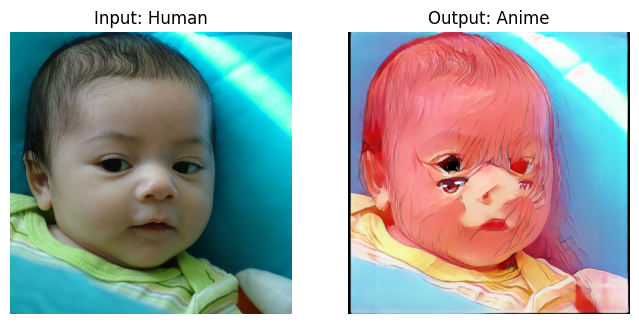

In [5]:
# Convert tensors to displayable images
real_img = sample_A[0].cpu() * 0.5 + 0.5
fake_img = fake_B[0].cpu() * 0.5 + 0.5

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(real_img.permute(1,2,0))
plt.title("Input: Human")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(fake_img.permute(1,2,0))
plt.title("Output: Anime")
plt.axis("off")

plt.show()

### 4.3 Batch Inference

To further evaluate generalization, we run inference on multiple
human face samples and visualize the results in a grid.

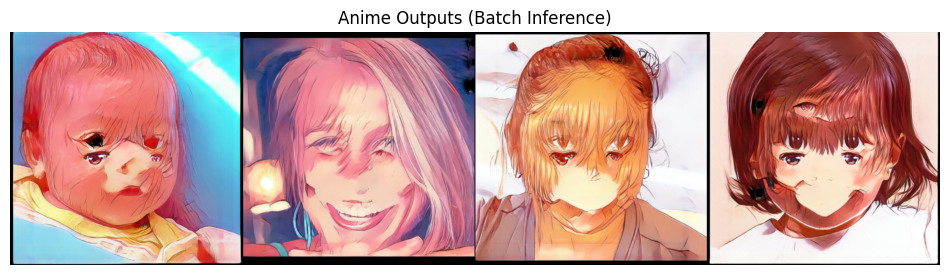

In [7]:
num_samples = 4
samples = []

for i in range(num_samples):
    img_A, _ = dataset[i]
    img_A = img_A.unsqueeze(0).to(device)

    with torch.no_grad():
        fake_B, _ = G_A2B(img_A)
        fake_B = fake_B[0].cpu() * 0.5 + 0.5
        samples.append(fake_B)

grid = make_grid(samples, nrow=num_samples)
plt.figure(figsize=(12,4))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.title("Anime Outputs (Batch Inference)")
plt.show()

### 4.4 Observations

From the qualitative results:

- The generator preserves the overall facial structure and pose of the
  input human images, and a recognizable resemblance to the original
  identity can be observed in many outputs.
- Basic facial layouts (eyes, nose, mouth placement) remain consistent
  between input and generated images, indicating successful structural
  mapping across domains.
- However, the anime-style translation is relatively weak:
  - Stylization is inconsistent across samples
  - Anime-specific features (e.g., exaggerated eyes, line-art clarity,
    color stylization) are not strongly expressed
- Generated images often appear closer to lightly stylized or smoothed
  human faces rather than clear anime-style illustrations.
- Some artifacts are present, particularly in hair regions and chin regions, which become more noticeable at higher resolution (512×512).

Overall, the results suggest that while UGATIT-Lite has learned to
preserve identity-related features and perform a stable domain mapping,
the strength of anime-style transformation remains limited and would
likely benefit from longer training, stronger style supervision, or a
more expressive generator architecture.

In [9]:
import os
import torch

# Create folder if it doesn't exist
os.makedirs("model", exist_ok=True)

# Load checkpoint
checkpoint = torch.load("checkpoints/latest.pth", map_location="cpu")

# Extract generator weights
G_A2B_state_dict = checkpoint["G_A2B"]

# Save generator only
torch.save(G_A2B_state_dict, "model/G_A2B.pth")

print("✅ Saved generator weights to model/G_A2B.pth")

✅ Saved generator weights to model/G_A2B.pth
